# Model Selection

## Packages

We begin by loading in necessary software packages, introducing options for saving the results, and software for computing PSIS LOO in Python.

In [1]:
from __future__ import division # For Python 2 compatibility
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import seaborn as sns
#%matplotlib notebook

import netCDF4 as nc4
import numpy as np
import pandas as pd
import logging

import pystan
import re
import time

In [2]:
# use test data (not all data is used for fitting/training)
use_testdata = False

# create plots of the data
show_data = True

# netCDF output file (set to None to not save output)
savename_output = 'core_models.nc'

# save the Stan output instead a few stats (only active if filename is specified above)
save_stan_output = True

# specify the Stan variable names to save; if set to None, all variables are saved 
# (only active if save_stan_output is True)
varnames_save = None

# the number of tries to fit each Stan model to achieve an R-hat < 1.1
num_tries = 3

# the number of chains to run
num_chains = 6

# the prior_only option passed to each Stan model
prior_only = False

In [3]:
"""Pareto smoothed importance sampling (PSIS)
This module implements Pareto smoothed importance sampling (PSIS) and PSIS
leave-one-out (LOO) cross-validation for Python (Numpy).
Included functions
------------------
psisloo
    Pareto smoothed importance sampling leave-one-out log predictive densities.
psislw
    Pareto smoothed importance sampling.
gpdfitnew
    Estimate the paramaters for the Generalized Pareto Distribution (GPD).
gpinv
    Inverse Generalised Pareto distribution function.
sumlogs
    Sum of vector where numbers are represented by their logarithms.
References
----------
Aki Vehtari, Andrew Gelman and Jonah Gabry (2017). Practical
Bayesian model evaluation using leave-one-out cross-validation
and WAIC. Statistics and Computing, 27(5):1413–1432.
doi:10.1007/s11222-016-9696-4. https://arxiv.org/abs/1507.04544
Aki Vehtari, Andrew Gelman and Jonah Gabry (2017). Pareto
smoothed importance sampling. https://arxiv.org/abs/arXiv:1507.02646v5
"""

# 3-Clause BSD License
"""
Copyright 2017 Aki Vehtari, Tuomas Sivula
Redistribution and use in source and binary forms, with or without modification,
are permitted provided that the following conditions are met:
1. Redistributions of source code must retain the above copyright notice, this
list of conditions and the following disclaimer.
2. Redistributions in binary form must reproduce the above copyright notice,
this list of conditions and the following disclaimer in the documentation and/or
other materials provided with the distribution.
3. Neither the name of the copyright holder nor the names of its contributors
may be used to endorse or promote products derived from this software without
specific prior written permission.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR
ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
(INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON
ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE. """


def psisloo(log_lik, **kwargs):
    r"""PSIS leave-one-out log predictive densities.
    Computes the log predictive densities given posterior samples of the log
    likelihood terms :math:`p(y_i|\theta^s)` in input parameter `log_lik`.
    Returns a sum of the leave-one-out log predictive densities `loo`,
    individual leave-one-out log predictive density terms `loos` and an estimate
    of Pareto tail indeces `ks`. The estimates are unreliable if tail index
    ``k > 0.7`` (see more in the references listed in the module docstring).
    Additional keyword arguments are passed to the :meth:`psislw()` function
    (see the corresponding documentation).
    Parameters
    ----------
    log_lik : ndarray
        Array of size n x m containing n posterior samples of the log likelihood
        terms :math:`p(y_i|\theta^s)`.
    Returns
    -------
    loo : scalar
        sum of the leave-one-out log predictive densities
    loos : ndarray
        individual leave-one-out log predictive density terms
    ks : ndarray
        estimated Pareto tail indeces
    """
    # ensure overwrite flag in passed arguments
    kwargs['overwrite_lw'] = True
    # log raw weights from log_lik
    lw = -log_lik
    # compute Pareto smoothed log weights given raw log weights
    lw, ks = psislw(lw, **kwargs)
    # compute
    lw += log_lik
    loos = sumlogs(lw, axis=0)
    loo = loos.sum()
    return loo, loos, ks


def psislw(lw, Reff=1.0, overwrite_lw=False):
    """Pareto smoothed importance sampling (PSIS).
    Parameters
    ----------
    lw : ndarray
        Array of size n x m containing m sets of n log weights. It is also
        possible to provide one dimensional array of length n.
    Reff : scalar, optional
        relative MCMC efficiency ``N_eff / N``
    overwrite_lw : bool, optional
        If True, the input array `lw` is smoothed in-place, assuming the array
        is F-contiguous. By default, a new array is allocated.
    Returns
    -------
    lw_out : ndarray
        smoothed log weights
    kss : ndarray
        Pareto tail indices
    """
    if lw.ndim == 2:
        n, m = lw.shape
    elif lw.ndim == 1:
        n = len(lw)
        m = 1
    else:
        raise ValueError("Argument `lw` must be 1 or 2 dimensional.")
    if n <= 1:
        raise ValueError("More than one log-weight needed.")

    if overwrite_lw and lw.flags.f_contiguous:
        # in-place operation
        lw_out = lw
    else:
        # allocate new array for output
        lw_out = np.copy(lw, order='F')

    # allocate output array for kss
    kss = np.empty(m)

    # precalculate constants
    cutoff_ind = - int(np.ceil(min(0.2 * n, 3 * np.sqrt(n / Reff)))) - 1
    cutoffmin = np.log(np.finfo(float).tiny)
    logn = np.log(n)
    k_min = 1/3

    # loop over sets of log weights
    for i, x in enumerate(lw_out.T if lw_out.ndim == 2 else lw_out[None, :]):
        # improve numerical accuracy
        x -= np.max(x)
        # sort the array
        x_sort_ind = np.argsort(x)
        # divide log weights into body and right tail
        xcutoff = max(
            x[x_sort_ind[cutoff_ind]],
            cutoffmin
        )
        expxcutoff = np.exp(xcutoff)
        tailinds, = np.where(x > xcutoff)
        x2 = x[tailinds]
        n2 = len(x2)
        if n2 <= 4:
            # not enough tail samples for gpdfitnew
            k = np.inf
        else:
            # order of tail samples
            x2si = np.argsort(x2)
            # fit generalized Pareto distribution to the right tail samples
            np.exp(x2, out=x2)
            x2 -= expxcutoff
            k, sigma = gpdfitnew(x2, sort=x2si)
        if k >= k_min and not np.isinf(k):
            # no smoothing if short tail or GPD fit failed
            # compute ordered statistic for the fit
            sti = np.arange(0.5, n2)
            sti /= n2
            qq = gpinv(sti, k, sigma)
            qq += expxcutoff
            np.log(qq, out=qq)
            # place the smoothed tail into the output array
            x[tailinds[x2si]] = qq
            # truncate smoothed values to the largest raw weight 0
            x[x > 0] = 0
        # renormalize weights
        x -= sumlogs(x)
        # store tail index k
        kss[i] = k

    # If the provided input array is one dimensional, return kss as scalar.
    if lw_out.ndim == 1:
        kss = kss[0]

    return lw_out, kss


def gpdfitnew(x, sort=True, sort_in_place=False, return_quadrature=False):
    """Estimate the paramaters for the Generalized Pareto Distribution (GPD)
    Returns empirical Bayes estimate for the parameters of the two-parameter
    generalized Parato distribution given the data.
    Parameters
    ----------
    x : ndarray
        One dimensional data array
    sort : bool or ndarray, optional
        If known in advance, one can provide an array of indices that would
        sort the input array `x`. If the input array is already sorted, provide
        False. If True (default behaviour), the array is sorted internally.
    sort_in_place : bool, optional
        If `sort` is True and `sort_in_place` is True, the array is sorted
        in-place (False by default).
    return_quadrature : bool, optional
        If True, quadrature points and weight `ks` and `w` of the marginal posterior distribution of k are also calculated and returned. False by
        default.
    Returns
    -------
    k, sigma : float
        estimated parameter values
    ks, w : ndarray
        Quadrature points and weights of the marginal posterior distribution
        of `k`. Returned only if `return_quadrature` is True.
    Notes
    -----
    This function returns a negative of Zhang and Stephens's k, because it is
    more common parameterisation.
    """
    if x.ndim != 1 or len(x) <= 1:
        raise ValueError("Invalid input array.")

    # check if x should be sorted
    if sort is True:
        if sort_in_place:
            x.sort()
            xsorted = True
        else:
            sort = np.argsort(x)
            xsorted = False
    elif sort is False:
        xsorted = True
    else:
        xsorted = False

    n = len(x)
    PRIOR = 3
    m = 30 + int(np.sqrt(n))

    bs = np.arange(1, m + 1, dtype=float)
    bs -= 0.5
    np.divide(m, bs, out=bs)
    np.sqrt(bs, out=bs)
    np.subtract(1, bs, out=bs)
    if xsorted:
        bs /= PRIOR * x[int(n/4 + 0.5) - 1]
        bs += 1 / x[-1]
    else:
        bs /= PRIOR * x[sort[int(n/4 + 0.5) - 1]]
        bs += 1 / x[sort[-1]]

    ks = np.negative(bs)
    temp = ks[:,None] * x
    np.log1p(temp, out=temp)
    np.mean(temp, axis=1, out=ks)

    L = bs / ks
    np.negative(L, out=L)
    np.log(L, out=L)
    L -= ks
    L -= 1
    L *= n

    temp = L - L[:,None]
    np.exp(temp, out=temp)
    w = np.sum(temp, axis=1)
    np.divide(1, w, out=w)

    # remove negligible weights
    dii = w >= 10 * np.finfo(float).eps
    if not np.all(dii):
        w = w[dii]
        bs = bs[dii]
    # normalise w
    w /= w.sum()

    # posterior mean for b
    b = np.sum(bs * w)
    # Estimate for k, note that we return a negative of Zhang and
    # Stephens's k, because it is more common parameterisation.
    temp = (-b) * x
    np.log1p(temp, out=temp)
    k = np.mean(temp)
    if return_quadrature:
        np.negative(x, out=temp)
        temp = bs[:, None] * temp
        np.log1p(temp, out=temp)
        ks = np.mean(temp, axis=1)
    # estimate for sigma
    sigma = -k / b * n / (n - 0)
    # weakly informative prior for k
    a = 10
    k = k * n / (n+a) + a * 0.5 / (n+a)
    if return_quadrature:
        ks *= n / (n+a)
        ks += a * 0.5 / (n+a)

    if return_quadrature:
        return k, sigma, ks, w
    else:
        return k, sigma


def gpinv(p, k, sigma):
    """Inverse Generalised Pareto distribution function."""
    x = np.empty(p.shape)
    x.fill(np.nan)
    if sigma <= 0:
        return x
    ok = (p > 0) & (p < 1)
    if np.all(ok):
        if np.abs(k) < np.finfo(float).eps:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            np.negative(x, out=x)
        else:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            x *= -k
            np.expm1(x, out=x)
            x /= k
        x *= sigma
    else:
        if np.abs(k) < np.finfo(float).eps:
            # x[ok] = - np.log1p(-p[ok])
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            np.negative(temp, out=temp)
            x[ok] = temp
        else:
            # x[ok] = np.expm1(-k * np.log1p(-p[ok])) / k
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            temp *= -k
            np.expm1(temp, out=temp)
            temp /= k
            x[ok] = temp
        x *= sigma
        x[p == 0] = 0
        if k >= 0:
            x[p == 1] = np.inf
        else:
            x[p == 1] = -sigma / k
    return x


def sumlogs(x, axis=None, out=None):
    """Sum of vector where numbers are represented by their logarithms.
    Calculates ``np.log(np.sum(np.exp(x), axis=axis))`` in such a fashion that
    it works even when elements have large magnitude.
    """
    maxx = x.max(axis=axis, keepdims=True)
    xnorm = x - maxx
    np.exp(xnorm, out=xnorm)
    out = np.sum(xnorm, axis=axis, out=out)
    if isinstance(out, np.ndarray):
        np.log(out, out=out)
    else:
        out = np.log(out)
    out += np.squeeze(maxx)
    return out

## Load Data

In [4]:
# load data
datafiles = {
    'seaflow':'data/SeaFlow_PSD_hourlyCOUNT_v3_regrid-25-8_day2.nc',
    #'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
    'zinser':'data/Zinser_SizeDist_logtransform-25-7.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

size_units = 'fg C cell$^{-1}$'

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]

    # create "counts" entry
    if 'count' in data_gridded[dataname]:
        data_gridded[dataname]['counts'] = (data_gridded[dataname]['count'][None,:] * data_gridded[dataname]['w_obs']).astype(int)
    elif 'abundance' in data_gridded[dataname]:
        logging.warning('{}: Using "abundance" data to generate count data for the model.'.format(dataname))
        data_gridded[dataname]['counts'] = (data_gridded[dataname]['count'][None,:] * data_gridded[dataname]['w_obs']).astype(int)
    else:
        raise RuntimeError('Cannot find a "count" or "abundance" entry in "{}".'.format(datafiles[dataname]))
        
    
    # add description
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

## Process Data

In [5]:
# prepare data for Stan model

seaflow_filter_par = False

if 'data' not in globals():
    data = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = None
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        if limit_days is None:
            limit_days = int(np.ceil(data[dataname]['t_obs'][-1]/1440))
        
        if seaflow_filter_par:
            # median filter PAR
            # see: medianfilter_par.ipynb
            n = len(data_gridded[dataname]['PAR'])
            wsh = 30 # half of median filter window size; window size is 2*wsh+1
            par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
        else:
            par = data_gridded[dataname]['PAR']
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        
        if not np.all(ind_obs):
            print('{}: limit_days is set to {}, removing {}/{} observation times'.format(dataname, limit_days, ind_obs.size-np.count_nonzero(ind_obs), ind_obs.size))
        
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    if use_testdata:
        # load cross-validation testing indices and add them to data
        data[dataname]['i_test'] = np.loadtxt(itestfiles[dataname]).astype(int)
        # remove last index, so that dimensions agree
        data[dataname]['i_test'] = data[dataname]['i_test'][:-1]
    else:
        # set all indices to zero
        data[dataname]['i_test'] = np.zeros(data[dataname]['nt_obs'], dtype=int)
        
    # switch on or off data fitting
    data[dataname]['prior_only'] = int(prior_only)
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # real count data
    data[dataname]['obs_count'] = data_gridded[dataname]['counts'][:, ind_obs]
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))

zinser: limit_days is set to 2, removing 1/25 observation times


## Model List

In [6]:
desc_model = {
    #'m1':'m1',
    'm2':'m2',
    #'m3':'m3',
    'm4':'m4',
    #'m5':'m5',
    #'m6':'m6',
    #'m7':'m7',
    #'m8':'m8',
    #'m9':'m9',
    #'m10':'m10',
    #'m11':'m11',
    #'m12':'m12',
    #'m13':'m13',
    #'m14':'m14',
    #'m3u':'m3u',
    #'m6u':'m6u',
    #'m7u':'m7u',
    #'m8u':'m8u',
    #'m9u':'m9u',
    #'m11u':'m11u',
    'm12u':'m12u',
    #'m13u':'m13u',
    #'m14u':'m14u',
    'm15':'m15',
    'm16':'m16',
    'm4s6':'m4 + spline6',
    'm12us6':'m12u + spline6',
    'm15s6':'m15 + spline6',
    'm16s6':'m16 + spline6',
}
# preparing for some regular expression magic
model_code_replacements = {
    'm1':(),
    'm2':(),
    'm3':(),
    'm4':(),
    'm5':(),
    'm6':(),
    'm7':(),
    'm8':(),
    'm9':(),
    'm10':(),
    'm11':(),
    'm12':(),
    'm13':(),
    'm14':(),
    'm3u':(),
    'm6u':(),
    'm7u':(),
    'm8u':(),
    'm9u':(),
    'm11u':(),
    'm12u':(),
    'm13u':(),
    'm14u':(),
    'm15':(),
    'm16':(),
    'm4s6':(('^( *int nknots = *)','6;'),),
    'm12us6':(('^( *int nknots = *)','6;'),),
    'm15s6':(('^( *int nknots = *)','6;'),),
    'm16s6':(('^( *int nknots = *)','6;'),),
}
model_stan_key = {
    'm1':'c1',
    'm2':'c2',
    'm3':'c3',
    'm4':'c4',
    'm5':'c5',
    'm6':'c6',
    'm7':'c7',
    'm8':'c8',
    'm9':'c9',
    'm10':'c10',
    'm11':'c11',
    'm12':'c12',
    'm13':'c13',
    'm14':'c14',
    'm3u':'c3u',
    'm6u':'c6u',
    'm7u':'c7u',
    'm8u':'c8u',
    'm9u':'c9u',
    'm11u':'c11u',
    'm12u':'c12u',
    'm13u':'c13u',
    'm14u':'c14u',
    'm15':'c15',
    'm16':'c16',
    'm4s6':'c4s',
    'm12us6':'c12us',
    'm15s6':'c15s',
    'm16s6':'c16s',
}
stan_files = {
    'c1':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_freedelta_normparam_trackgrowthvol_xval2.stan',
    'c2':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_normparam_trackgrowthvol_xval2.stan',
    'c3':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_gammaiv6_normparam_trackgrowthvol_xval2.stan',
    'c4':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv1_normparam_trackgrowthvol_xval2.stan',
    'c5':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv2_normparam_trackgrowthvol_xval2.stan',
    'c6':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv6_normparam_trackgrowthvol_xval2.stan',
    'c7':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv7_normparam_trackgrowthvol_xval2.stan',
    'c8':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv6_normparam_trackgrowthvol_xval2.stan',
    'c9':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv7_normparam_trackgrowthvol_xval2.stan',
    'c10':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respv2_normparam_trackgrowthvol_xval2.stan',
    'c11':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv6_normparam_trackgrowthvol_xval2.stan',
    'c12':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv7_normparam_trackgrowthvol_xval2.stan',
    'c13':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv6_normparam_trackgrowthvol_xval2.stan',
    'c14':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv7_normparam_trackgrowthvol_xval2.stan',
    'c3u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_gammaiv8_normparam_trackgrowthvol_xval2.stan',
    'c6u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv8_normparam_trackgrowthvol_xval2.stan',
    'c7u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv9_normparam_trackgrowthvol_xval2.stan',
    'c8u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv8_normparam_trackgrowthvol_xval2.stan',
    'c9u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv9_normparam_trackgrowthvol_xval2.stan',
    'c11u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv8_normparam_trackgrowthvol_xval2.stan',
    'c12u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv9_normparam_trackgrowthvol_xval2.stan',
    'c13u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv8_normparam_trackgrowthvol_xval2.stan',
    'c14u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv9_normparam_trackgrowthvol_xval2.stan',
    'c15':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_freegamma_normparam_trackgrowthvol_xval2.stan',
    'c16':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_freeresp_freegamma_normparam_trackgrowthvol_xval2.stan',
    'c4s':'../g3_timedep/matrixmodel_mlmultinom_estinilnorm2_monodelta2-timespline_respv1_normparam_trackgrowthvol_xval2.stan',
    'c12us':'../g3_timedep/matrixmodel_mlmultinom_estinilnorm2_monodelta2-timespline_resp_gammaiv9_normparam_trackgrowthvol_xval2.stan',
    'c15s':'../g3_timedep/matrixmodel_mlmultinom_estinilnorm2_monodelta2-timespline_resp_freegamma_normparam_trackgrowthvol_xval2.stan',
    'c16s':'../g3_timedep/matrixmodel_mlmultinom_estinilnorm2_monodelta2-timespline_freeresp_freegamma_normparam_trackgrowthvol_xval2.stan',
}

## Load Results

In [7]:
load = True  # change to True if you want to load models
if load:
    mcmcs = {}
    with nc4.Dataset(savename_output) as nc:
        datafiles = nc.groups.keys()
        for dataname in datafiles:
            models = nc[dataname].groups.keys()
            for name in models:
                # Loop is structured weirdly because the hierarchy of model output
                # and saved results is reversed
                if name not in mcmcs.keys():
                    mcmcs[name] = {}
                if dataname not in mcmcs[name].keys():
                    mcmcs[name][dataname] = {}
                for var in nc[dataname][name].variables:
                    mcmcs[name][dataname][var] = nc[dataname][name].variables[var][:]

## Compute PSIS LOO for Model Selection

In [8]:
log_liks = {}
for name in models:
    log_liks[name] = {}
    for dataname in datafiles:
        log_liks[name][dataname] = mcmcs[name][dataname]['lp__']

In [9]:
loos = {}
loo_sums = {}
k = {}

for name in models:
    loos[name] = {}
    loo_sums[name] = {}
    k[name] = {}
    for dataname in datafiles:
        loozn, looszn, kszn = psisloo(np.asarray(mcmcs[name][dataname]['lp__']))
        loos[name][dataname] = looszn
        loo_sums[name][dataname] = loozn
        k[name][dataname] = kszn

In [10]:
for dataname in datafiles:
    print('{} dataset'.format(dataname))
    print('----------------------------')
    print('Model \t PSIS-LOO \t k')
    print('----- \t ---------- \t ----')
    for name in models:
        print('{} \t {} \t {}'.format(name, np.round(loos[name][dataname]), np.round(k[name][dataname], 2)))
    print('\n\n')

seaflow dataset
----------------------------
Model 	 PSIS-LOO 	 k
----- 	 ---------- 	 ----
m2 	 -855417.0 	 5.73
m4 	 -855424.0 	 6.34
m12u 	 -855410.0 	 5.43
m15 	 -855324.0 	 6.01
m16 	 -854974.0 	 7.16
m4s6 	 -855388.0 	 5.23
m12us6 	 -855380.0 	 6.65
m15s6 	 -855258.0 	 6.76
m16s6 	 -854976.0 	 6.81



zinser dataset
----------------------------
Model 	 PSIS-LOO 	 k
----- 	 ---------- 	 ----
m2 	 -1358681.0 	 6.25
m4 	 -1358505.0 	 5.87
m12u 	 -1358381.0 	 6.79
m15 	 -1358310.0 	 6.49
m16 	 -1357987.0 	 5.94
m4s6 	 -1358410.0 	 6.7
m12us6 	 -1358052.0 	 6.34
m15s6 	 -1357963.0 	 7.0
m16s6 	 -1357758.0 	 6.35





In [11]:
for dataname in datafiles:
    temp = {}
    for name in models:
        temp[name] = loos[name][dataname]
    print(dataname)
    print(sorted(temp, key=temp.get, reverse=True))
    print('\n')

seaflow
['m16', 'm16s6', 'm15s6', 'm15', 'm12us6', 'm4s6', 'm12u', 'm2', 'm4']


zinser
['m16s6', 'm15s6', 'm16', 'm12us6', 'm15', 'm12u', 'm4s6', 'm4', 'm2']




## Some Plotting Parameters

In [12]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# set the color for each model
num_model = len(mcmcs)
if num_model <= 10:
    colors_model = {model:'C{}'.format(imodel) for imodel,model in enumerate(mcmcs)}
else:
    colors_model = {model:mpl.cm.viridis(imodel/(num_model-1)) for imodel,model in enumerate(mcmcs)}
    
# maxrhats_final = {model:{dataname:get_max_rhat(mcmcs[model][dataname]) for dataname in data} for model in mcmcs}

In [13]:
param_desc = {'divrate':'daily division rate','E_star':'E*'}
# add known values here
reference_values = {'zinser':{'divrate':0.69}}

# Figures

### Figure 1

The idea of this figure is to introduce the reader to the Zinser dataset, give them a sense of what the data looks like, and frame the modeling objective as estimating the dynamics we show here.

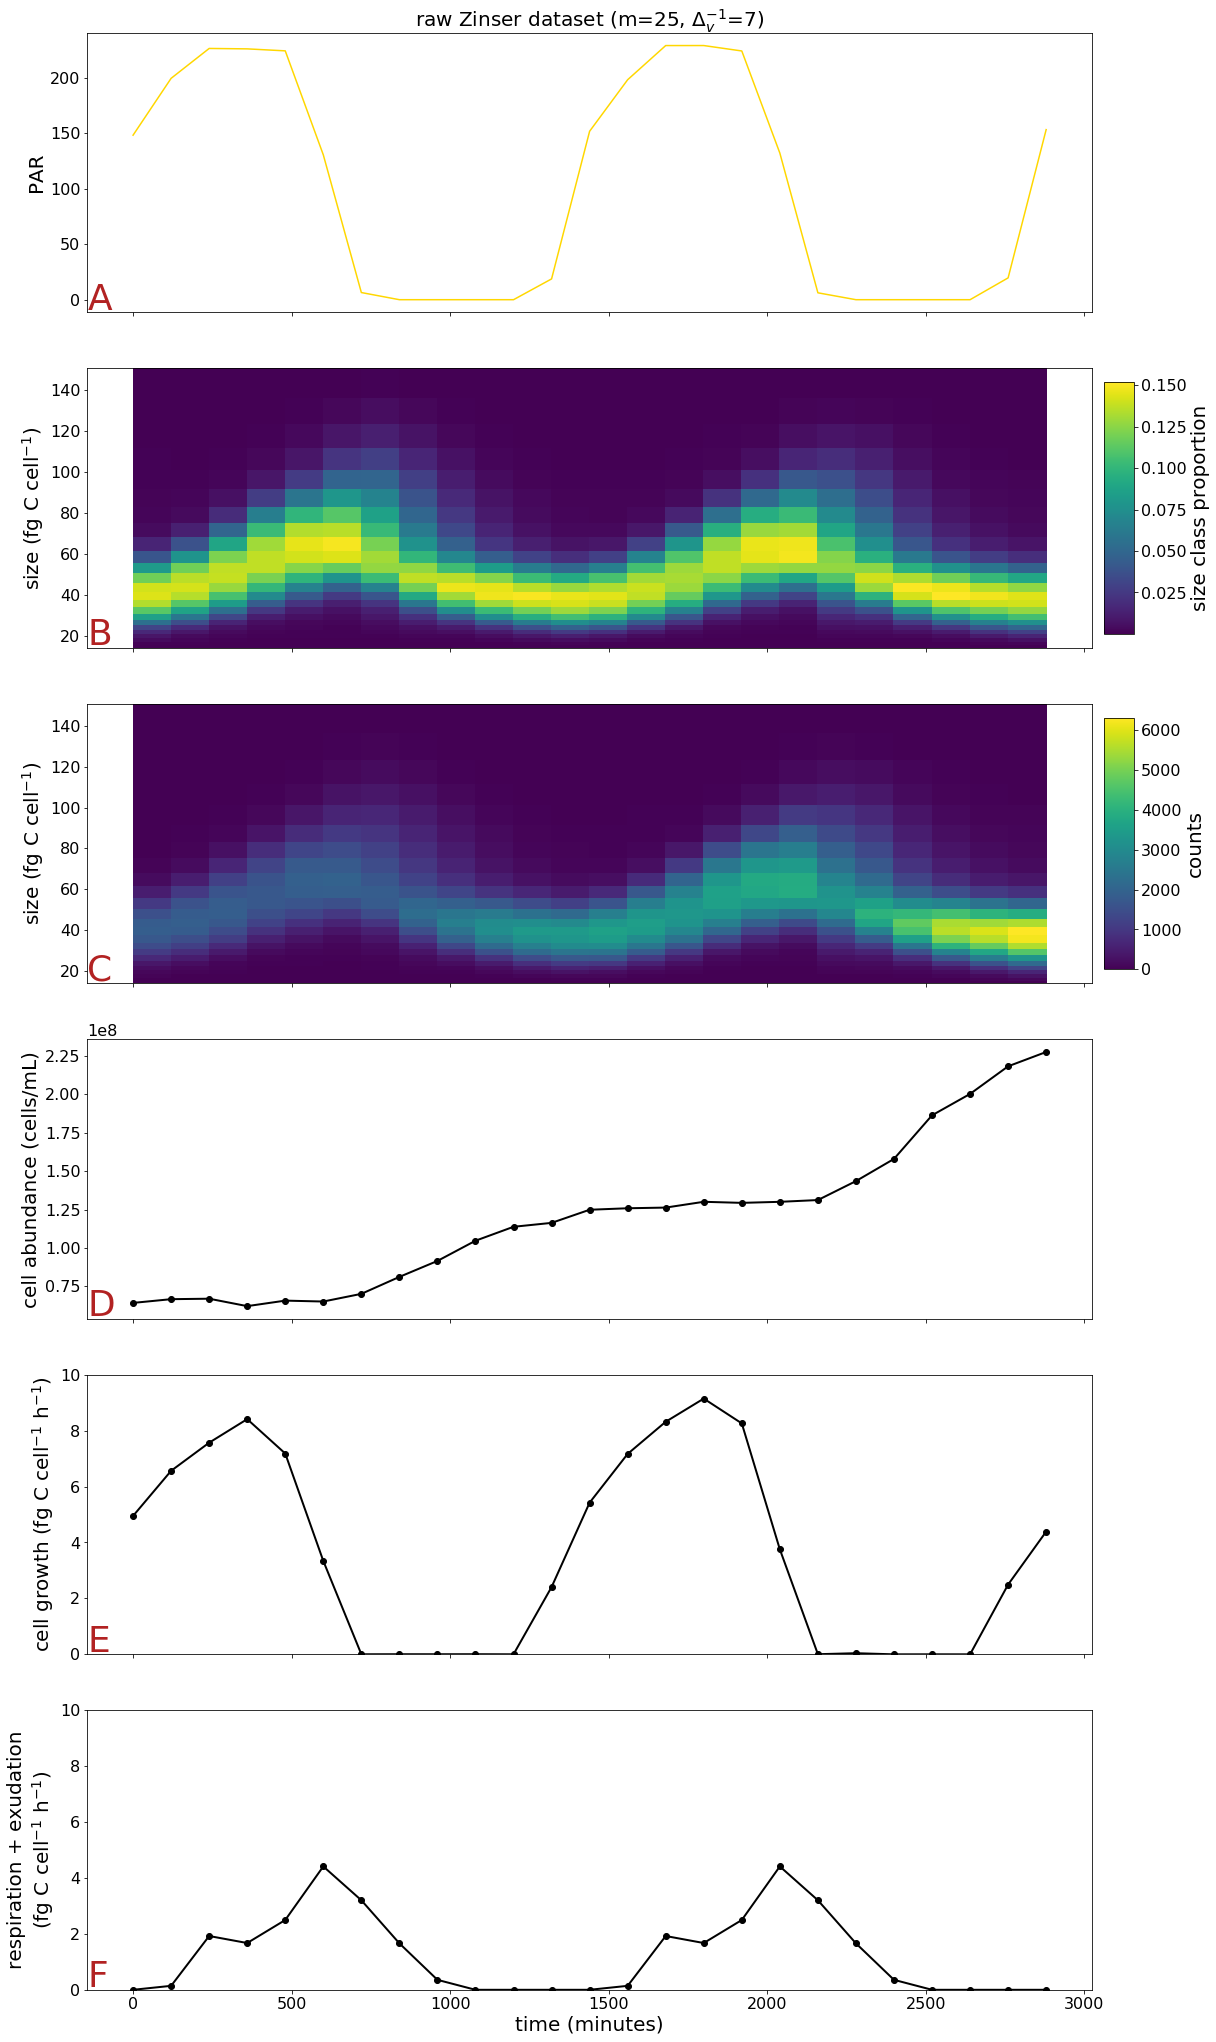

In [14]:
def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1),
                            bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'

prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'respiration + exudation\n({} h$^{{-1}}$)'.format(size_units),
}

fontsize = 36

if show_data:
    for i,dataname in enumerate(data_gridded):
        if 'zinser' in dataname:
            nrows = 6

            v_min = data_gridded[dataname]['v_min']
            delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
            v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 

            fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(18,6*nrows))

            ax = axs[0]
            ax.set_title('raw '+desc[dataname], size=20)
            ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
            ax.set(ylabel='PAR')
            ax.text(0, 0.01, 'A', transform = ax.transAxes, color='firebrick', fontsize=fontsize)

            ax = axs[1]
            pc = ax.pcolormesh(data_gridded[dataname]['time'], v, data_gridded[dataname]['w_obs'], shading='auto')
            ax.set(ylabel='size ({})'.format(size_units))
            #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
            add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
            ax.text(0, 0.01, 'B', transform = ax.transAxes, color='firebrick', fontsize=fontsize)

            ax = axs[2]
            pc = ax.pcolormesh(data_gridded[dataname]['time'], v, data_gridded[dataname]['counts'], shading='auto')
            ax.set(ylabel='size ({})'.format(size_units))
            #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
            add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
            ax.text(0, 0.01, 'C', transform = ax.transAxes, color='firebrick', fontsize=fontsize)
            
            ax = axs[3]
            pc = ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['abundance'], color='black',
                        marker='o', lw=2)
            ax.set(ylabel='cell abundance (cells/mL)')
            ax.text(0, 0.01, 'D', transform = ax.transAxes, color='firebrick', fontsize=fontsize)
            
            ax = axs[4]
            ylim = (0, 10)
            prop = 'growth'
            with nc4.Dataset('data/zinser_growthdivresp.nc') as nc:
                pc = ax.plot(data_gridded[dataname]['time'], np.maximum(0.0, nc[prop+'/'+prop][:]), color='black',
                             marker='o', lw=2)
            ax.set(ylabel=prop_labels[prop], ylim=ylim)
            ax.text(0, 0.01, 'E', transform = ax.transAxes, color='firebrick', fontsize=fontsize)
            
            ax = axs[5]
            prop = 'respiration'
            with nc4.Dataset('data/zinser_growthdivresp.nc') as nc:
                pc = ax.plot(data_gridded[dataname]['time'], np.maximum(0.0, nc[prop+'/'+prop][:]), color='black', marker='o', lw=2)
            ax.set(ylabel=prop_labels[prop], ylim=ylim)
            ax.set_xlabel('time (minutes)')
            ax.text(0, 0.01, 'F', transform = ax.transAxes, color='firebrick', fontsize=fontsize)
None

### Figure 2

The idea behind this figure is to show the model inference on the "big picture" daily population dynamics. We also show PSIS-LOO scores as a metric that balances model fit with model complexity. The green vertical lines indicate the "true" values of each daily quantity calculated from the data.

TODO: Add additional lines to indicate model results for current version of MPM as a baseline for comparison. Potentially also add Ek and model misfit.

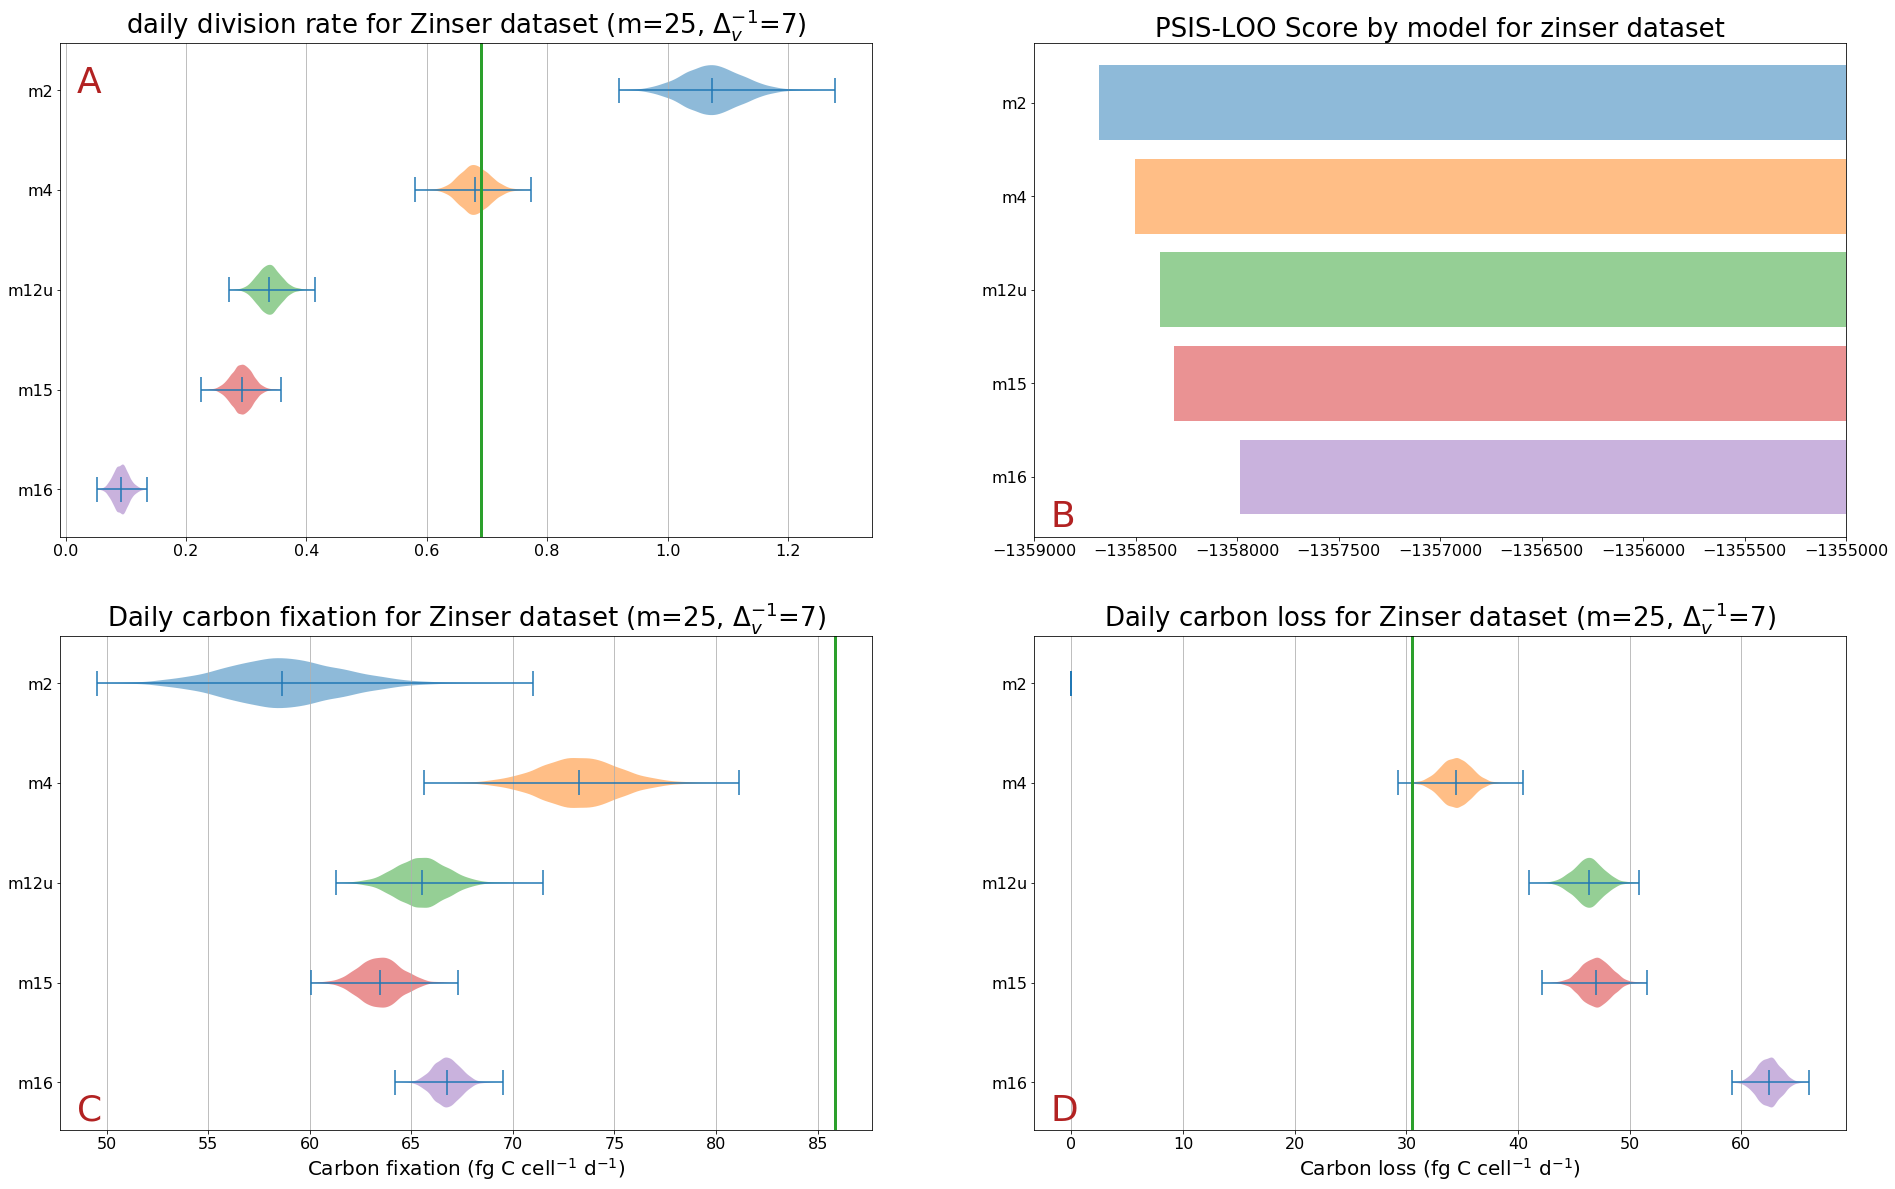

In [15]:
if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'

prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'respiration + exudation\n({} h$^{{-1}}$)'.format(size_units),
}

for dataname in ['zinser']:
    for param in ('divrate',):
        temp_mcmcs = {key: mcmcs[key] for key in mcmcs if 's6' not in key}
        num_mcmcs = len(temp_mcmcs)
        fig, axs = plt.subplots(2, 2, figsize=(32,4*num_mcmcs))
        
        ax = axs[0, 0]
        ax.set_title('{} for {}'.format(param_desc[param], desc[dataname]))
        plot = ax.violinplot([temp_mcmcs[model][dataname][param] for model in temp_mcmcs],
                             showmedians=True, vert=False)
        ii = 0
        for pc in plot['bodies']:
            pc.set_facecolor(colors_model[list(models)[ii]])
            pc.set_alpha(0.5)
            ii += 1
        ax.invert_yaxis()
        ax.grid(axis='x')
        ax.set(yticks=np.arange(1,num_mcmcs+1),
               yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs])
        if dataname in reference_values and param in reference_values[dataname]:
            ax.axvline(reference_values[dataname][param], color='tab:green', lw=3)
        ax.text(0.02, 0.9, 'A', transform = ax.transAxes, color='firebrick', fontsize=fontsize)

        ax = axs[0, 1]
        ax.barh(np.arange(len(temp_mcmcs)),
                    [float(loos[model][dataname]) for model in temp_mcmcs],
                    color=[colors_model[model] for model in temp_mcmcs], alpha=0.5)
        ax.invert_yaxis()
        if 'zinser' in dataname:
            ax.set_xlim(-1359000, -1355000)
        elif 'seaflow' in dataname:
            ax.set_xlim(-856000, -852000)
        ax.set_title('PSIS-LOO Score by model for {} dataset'.format(dataname))
        ax.set(yticks=np.arange(0,num_mcmcs),
               yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs])
        ax.text(0.02, 0.02, 'B', transform = ax.transAxes, color='firebrick', fontsize=fontsize)

        t = data[dataname]['dt']*np.arange(data[dataname]['nt'])/60.0
        dt_h = data[dataname]['dt']/60.0
        
        daily_props = {}
        
        for prop in ['growth', 'respiration']:
            
            daily_props[prop] = {}
            
            for model in temp_mcmcs:

                cell_count = temp_mcmcs[model][dataname]['cell_count']

                if prop == 'growth':
                    plotprop = temp_mcmcs[model][dataname]['growth_size_gain']/cell_count/dt_h
                    x = t
                elif prop == 'respiration':
                    plotprop = temp_mcmcs[model][dataname]['resp_size_loss']/cell_count/dt_h
                    x = t
                else:
                    raise ValueError('Unknown prop "{}".'.format(prop))
                
                daily_prop = np.mean(plotprop, axis=1)*24
                
                daily_props[prop][model] = daily_prop
                
        for ax, prop in zip(axs[1, :], ('growth', 'respiration')):
            labels = {'growth': 'C', 'respiration': 'D'}
            if dataname == 'zinser':
                with nc4.Dataset('data/zinser_growthdivresp.nc') as nc:
                    true_prop = np.mean(np.maximum(0.0, nc[prop+'/'+prop][:]))*24
            
            title_labels = {'growth': 'carbon fixation', 'respiration': 'carbon loss'}
            xlabels = {'growth': 'Carbon fixation ({} d$^{{-1}}$)'.format(size_units),
                      'respiration': 'Carbon loss ({} d$^{{-1}}$)'.format(size_units)}
            
            ax.set_title('{} for {}'.format('Daily {}'.format(title_labels[prop]), desc[dataname]))
            plot = ax.violinplot([daily_props[prop][model] for model in daily_props[prop]],
                                 showmedians=True, vert=False)
            ax.set(xlabel=xlabels[prop])
            ii = 0
            for pc in plot['bodies']:
                pc.set_facecolor(colors_model[list(models)[ii]])
                pc.set_alpha(0.5)
                ii += 1
            ax.invert_yaxis()
            ax.grid(axis='x')
            ax.set(yticks=np.arange(1,num_mcmcs+1),
                   yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs])
            if 'zinser' in dataname:
                ax.axvline(true_prop, color='tab:green', lw=3)
            if dataname in reference_values and prop in reference_values[dataname]:
                ax.axvline(reference_values[dataname][param], color='tab:green', lw=3)
            ax.text(0.02, 0.02, labels[prop], transform = ax.transAxes, color='firebrick', fontsize=fontsize)

### Figure 3

The idea of this figure is to look further under the hood of the model, and see what the model parameters are applying is happening on an hourly time scale. This reveals that the model has limitations on high-resolution time scales, most notably the lag in the timing of peak division.

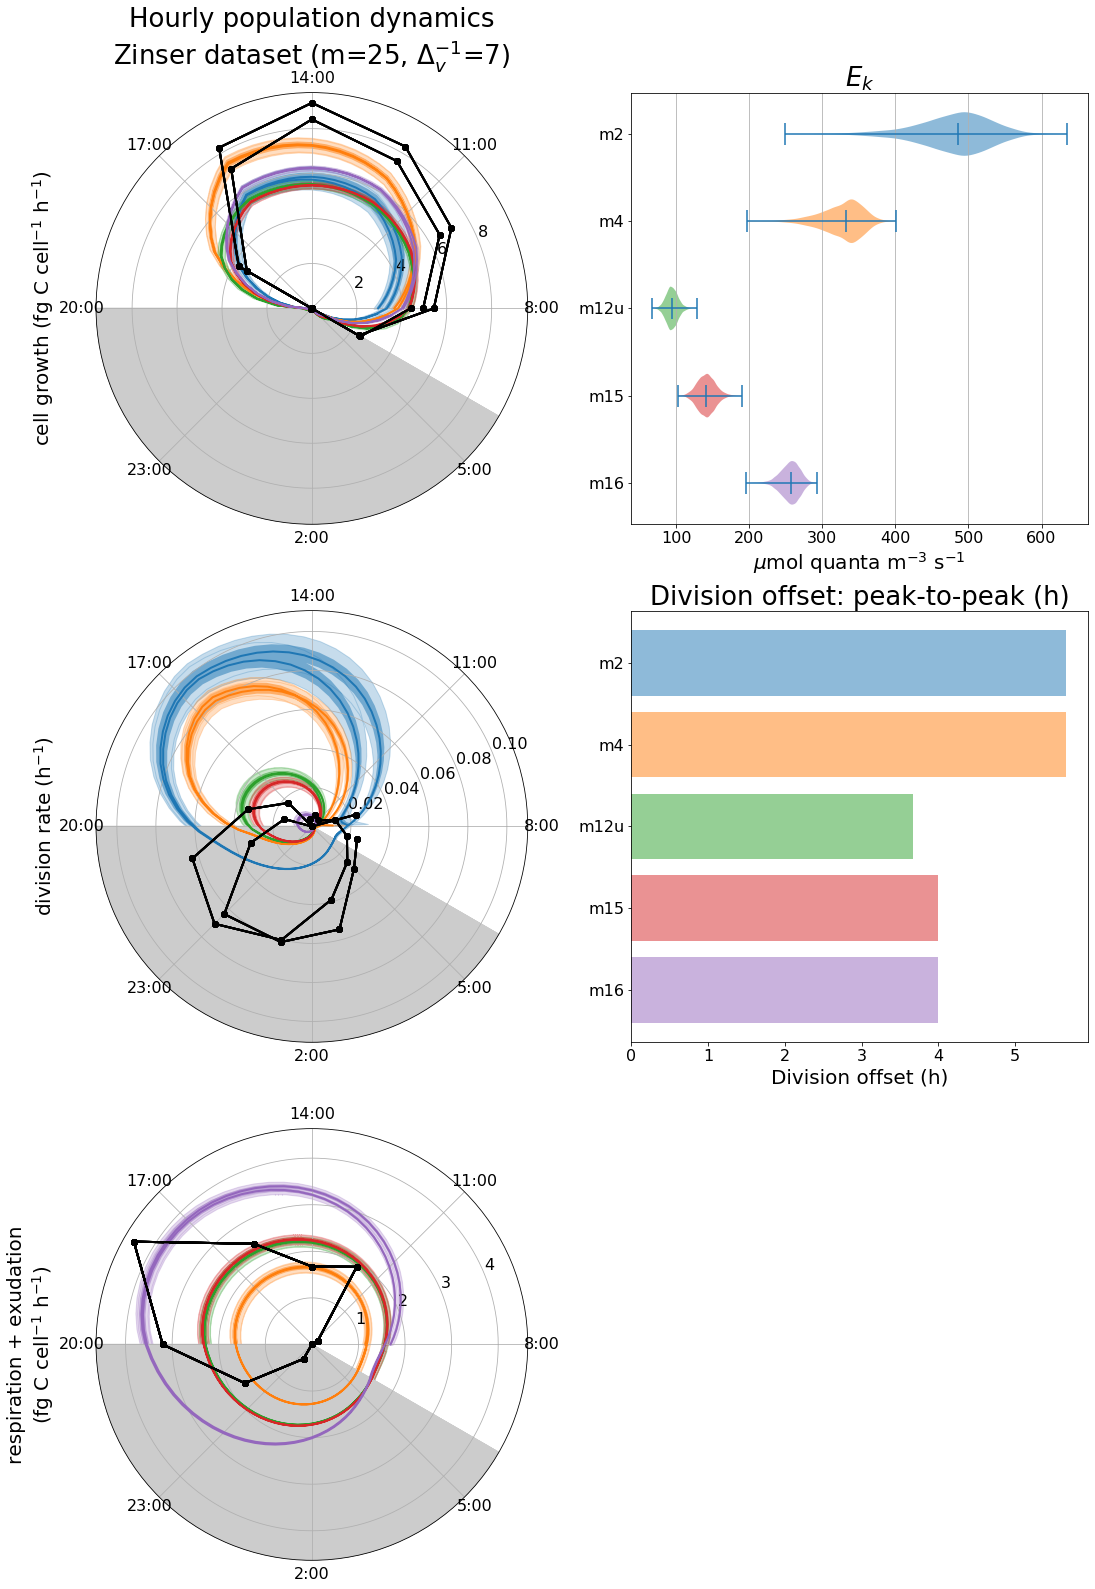

In [16]:
if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'
prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'respiration + exudation\n({} h$^{{-1}}$)'.format(size_units),
}
for dataname in ['zinser']:
    fig = plt.figure(figsize=(9*2, 9*3))
    temp_mcmcs = {key: mcmcs[key] for key in mcmcs if 's6' not in key}
    t = data[dataname]['dt']*np.arange(data[dataname]['nt'])/60.0
    dt_h = data[dataname]['dt']/60.0
    
    grids = gridspec.GridSpec(1, 2, figure=fig)
    
    polar_grid = grids[0].subgridspec(3, 1)
    
    ii = 0
    mod_maxes = {}
    for prop in ('growth', 'division', 'respiration'):
        ax = fig.add_subplot(polar_grid[ii], polar=True)
        
        for model in temp_mcmcs:
            cell_count = temp_mcmcs[model][dataname]['cell_count']
        
            if prop == 'growth':
                plotprop = temp_mcmcs[model][dataname]['growth_size_gain']/cell_count/dt_h
                x = t * (np.pi/12.0)
            elif prop == 'division':
                plotprop = (np.log(cell_count[:,1:])-np.log(cell_count[:,:-1]))/(t[1:]-t[:-1])
                x = 0.5 * (t[1:] + t[:-1]) * (np.pi/12.0)
                temp = np.mean(plotprop, axis=0)
                mod_max = np.where(temp == np.max(temp[0:72]))[0][0]/3
                mod_maxes[model] = mod_max
            elif prop == 'respiration':
                plotprop = temp_mcmcs[model][dataname]['resp_size_loss']/cell_count/dt_h
                x = t * (np.pi/12.0)
            else:
                raise ValueError('Unknown prop "{}".'.format(prop))
            qq = np.percentile(plotprop, q=(5,25,50,75,95), axis=0)
            sc = ax.fill_between(x, qq[0,:], qq[-1,:], alpha=0.25, color=colors_model[model])
            ax.fill_between(x, qq[1,:], qq[-2,:], alpha=0.5, facecolor=sc.get_facecolor()[0])
            ax.plot(x, qq[2,:], color=sc.get_facecolor()[0][:-1], lw=2)
            if dataname == 'zinser':
                with nc4.Dataset('data/zinser_growthdivresp.nc') as nc:
                    ax.plot(nc[prop+'/time'][:]*(np.pi/12.0), np.maximum(0.0, nc[prop+'/'+prop][:]),
                            color='black', marker='o', lw=2)
                    if prop == 'division':
                        temp = np.maximum(0.0, nc[prop+'/'+prop][:])
                        true_max = np.where(temp == np.max(temp[0:12]))[0][0]*2
            ax.set_ylim(bottom=0.0)
            ax.set_ylabel(prop_labels[prop], labelpad=40)
            ax.set_xticklabels(['{:d}:{:02d}'.format((int(t*(12/np.pi)+8)%24), int(60*(t*(12/np.pi)%1.0)))
                                for t in ax.get_xticks()])
            # darkness from 20:00 to 6:00
            # ymax > 1 needed because it's a polar plot
            ax.axvspan(720*(np.pi/720.0), (1440-120)*(np.pi/720.0), color='0.8', ymax=10, zorder=1)
            ax.grid(True)
        if ii == 0:
            ax.set_title('Hourly population dynamics' + '\n' + desc[dataname])
        ii += 1
    
    reg_grid = grids[1].subgridspec(3, 1)
    
    param = 'E_star'
    ax = fig.add_subplot(reg_grid[0])
    plot = ax.violinplot([temp_mcmcs[model][dataname][param] for model in temp_mcmcs],
                             showmedians=True, vert=False)
    ii = 0
    for pc in plot['bodies']:
        pc.set_facecolor(colors_model[list(models)[ii]])
        pc.set_alpha(0.5)
        ii += 1
    ax.invert_yaxis()
    ax.grid(axis='x')
    ax.set(yticks=np.arange(1,num_mcmcs+1),
           yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs])
    ax.set_title(r'$E_k$')
    ax.set_xlabel(r'$\mu$mol quanta m$^{-3}$ s$^{-1}$')
    if dataname in reference_values and param in reference_values[dataname]:
        ax.axvline(reference_values[dataname][param], color='tab:green', lw=3)
        
    ax = fig.add_subplot(reg_grid[1])
    div_lag = [true_max - mod_maxes[model] for model in temp_mcmcs]
    ax.barh(np.arange(len(temp_mcmcs)),
                    div_lag,
                    color=[colors_model[model] for model in temp_mcmcs], alpha=0.5)
    ax.invert_yaxis()
    ax.set_title('Division offset: peak-to-peak (h)')
    ax.set(yticks=np.arange(0,num_mcmcs),
           yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs],
           xlabel='Division offset (h)')

### Figure 4

Here we investigate why we get this consistent lag in the division timing in our models. By plotting the mean cell size at each time point against hourly division rate, we can see that cell size alone is not a great predictor of division rate for this dataset. However, when we look at cell size at t-6 hours and division rate at t, we see that there is quite a strong correlation which demonstrates that there may be some 6-hour "lag" process with respect to cell size and division (e.g. mitosis).

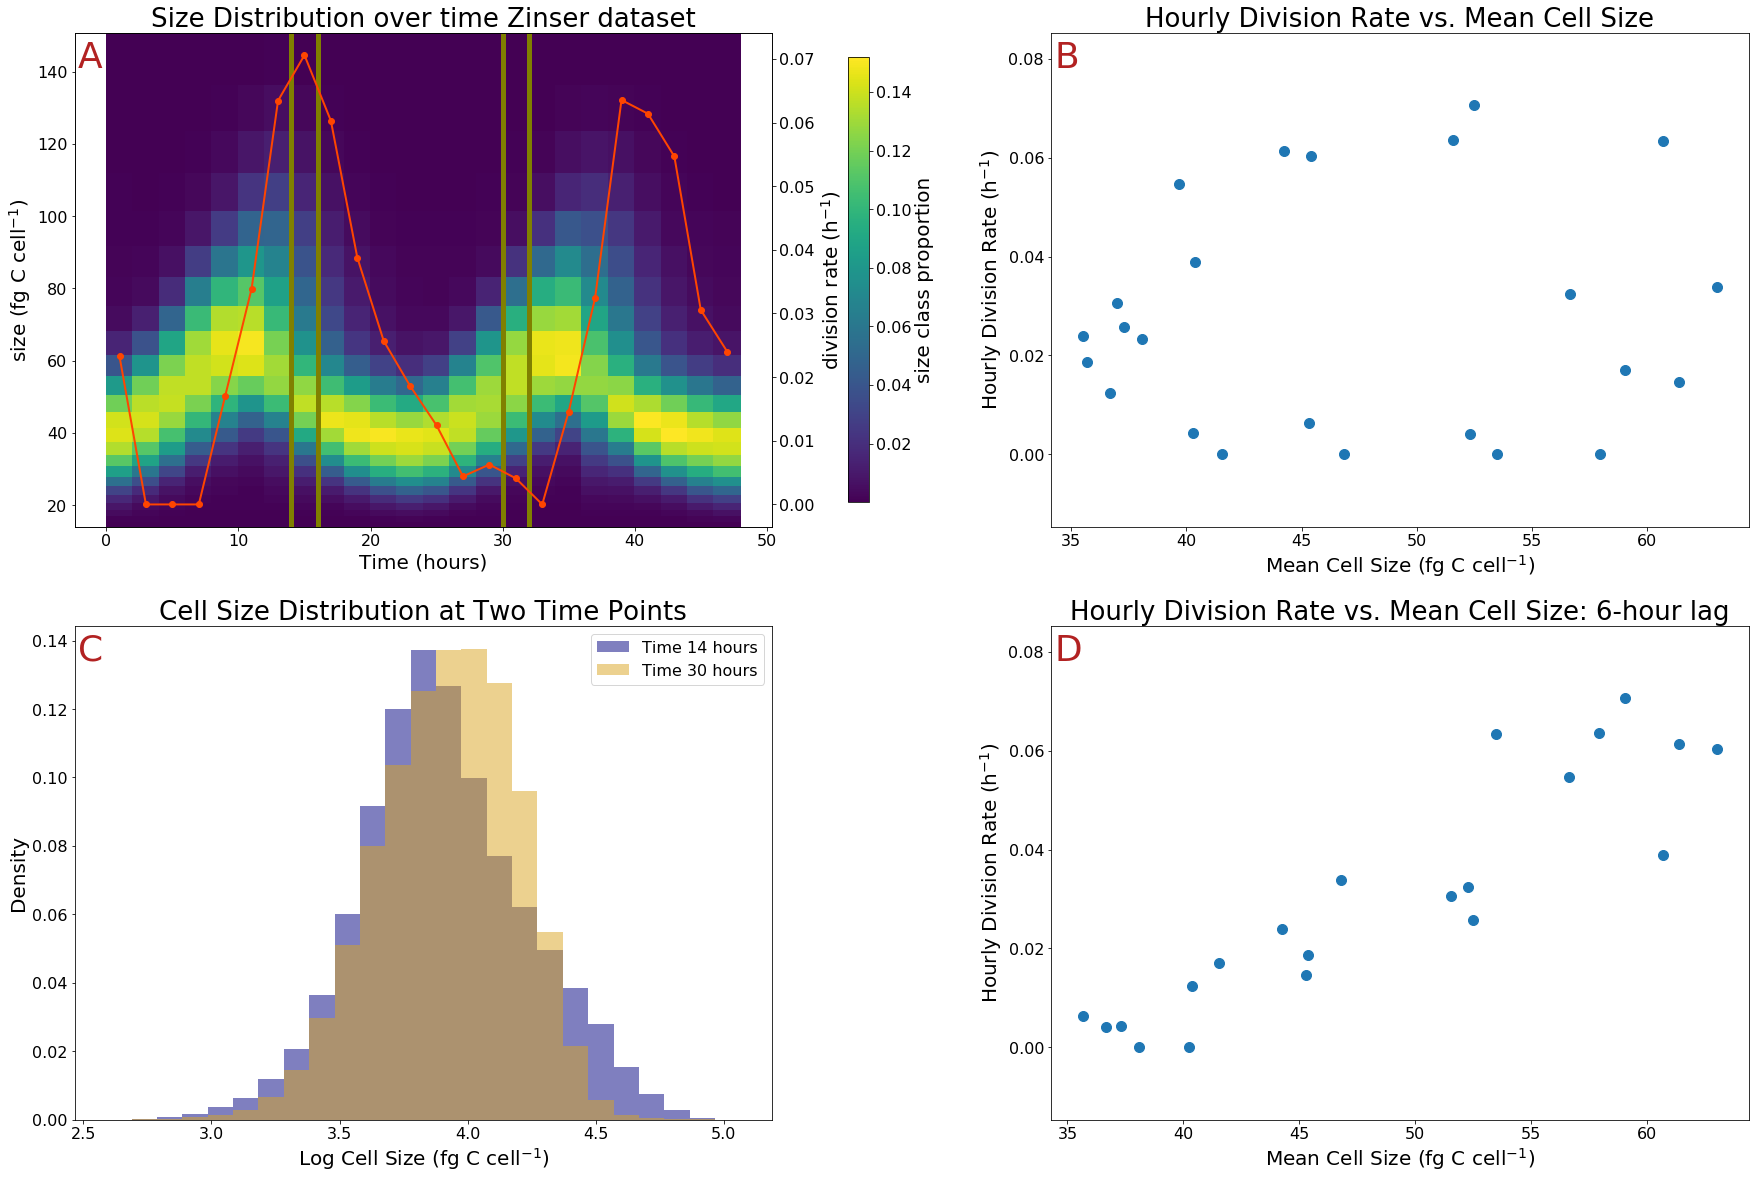

<Figure size 1728x864 with 0 Axes>

In [17]:
if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'
    
def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.15,0.0,1,1),
                            bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'respiration + exudation\n({} h$^{{-1}}$)'.format(size_units),
}

dataname = 'zinser'

fig, axs = plt.subplots(2, 2, figsize=(30, 20))
plt.subplots_adjust(wspace=0.4)
ax = axs[0, 0]
pc = ax.pcolormesh(data_gridded[dataname]['time']/60, v, data_gridded[dataname]['w_obs'], shading='auto')
ax.set(ylabel='size ({})'.format(size_units))
#ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
ax.set_title('Size Distribution over time Zinser dataset')
ax.set_xlabel('Time (hours)')
time1 = 14
time2 = 30
ylim = ax.get_ylim()
xlim = ax.get_xlim()
ax.axvline(x=time1, ymin=0, ymax=1, lw=5, color='olive')
ax.axvline(x=time1+2, ymin=0, ymax=1, lw=5, color='olive')
ax.axvline(x=time2, ymin=0, ymax=1, lw=5, color='olive')
ax.axvline(x=time2+2, ymin=0, ymax=1, lw=5, color='olive')

with nc4.Dataset('data/zinser_growthdivresp.nc') as nc:
    prop = 'division'
    ax = ax.twinx()
    hourly_div = np.maximum(0.0, nc[prop+'/'+prop][:])
    ax.plot(nc[prop+'/time'][:], hourly_div,
            color='orangered', marker='o', lw=2)
    ax.set_ylabel(prop_labels[prop])

ax.text(0.005, 0.93, 'A', transform = ax.transAxes, color='firebrick', fontsize=fontsize)

ax = axs[0, 1]
mean_size = []
for ii in range(len(data['zinser']['t_obs'])):
    mean_size.append(np.sum(data['zinser']['obs'][:, ii].flatten()*v))
ax.scatter(mean_size, hourly_div, s=100)
ax.set_title('Hourly Division Rate vs. Mean Cell Size')
ax.set_xlabel('Mean Cell Size ({})'.format(size_units))
ax.set_ylabel('Hourly Division Rate (h$^{-1}$)')
ax.text(0.005, 0.93, 'B', transform = ax.transAxes, color='firebrick', fontsize=fontsize)

ax = axs[1, 1]
lag = 6  # lag in hours
ax.scatter(mean_size[:-int(lag/2)], hourly_div[int(lag/2):], s=100)
ax.set_title('Hourly Division Rate vs. Mean Cell Size: {}-hour lag'.format(lag))
ax.set_xlabel('Mean Cell Size ({})'.format(size_units))
ax.set_ylabel('Hourly Division Rate (h$^{-1}$)')
ax.text(0.005, 0.93, 'D', transform = ax.transAxes, color='firebrick', fontsize=fontsize)

ax = axs[1, 0]
# sns.distplot(data_gridded['zinser']['counts'][:, int(time1/2)], hist = False, kde = True,
#                  kde_kws = {'linewidth': 5}, ax=ax, color='navy', label='Time {} hours'.format(time1))
# sns.distplot(data_gridded['zinser']['counts'][:, int(time2/2)], hist = False, kde = True,
#                  kde_kws = {'linewidth': 5}, ax=ax, color='goldenrod', label='Time {} hours'.format(time2))
space = (np.log(v[1]) - np.log(v[0]))
ax.bar(np.log(v), data_gridded['zinser']['w_obs'][:, int(time1/2)], width=space, color='navy',
       label='Time {} hours'.format(time1), alpha=0.5)
ax.bar(np.log(v), data_gridded['zinser']['w_obs'][:, int(time2/2)], width=space, color='goldenrod',
       label='Time {} hours'.format(time2), alpha=0.5)
ax.legend()
# ax.bar(v, data_gridded['zinser']['w_obs'][:, int(time2/2)])
ax.set_title('Cell Size Distribution at Two Time Points')
ax.set_xlabel('Log Cell Size ({})'.format(size_units))
ax.set_ylabel('Density')
ax.text(0.005, 0.93, 'C', transform = ax.transAxes, color='firebrick', fontsize=fontsize)

plt.show()
plt.close()
plt.subplots_adjust(wspace=0.2)  # set back to default
None

Now we introduce models with time-dependent division to try to account for the 6-hour lag.

### Figure 5

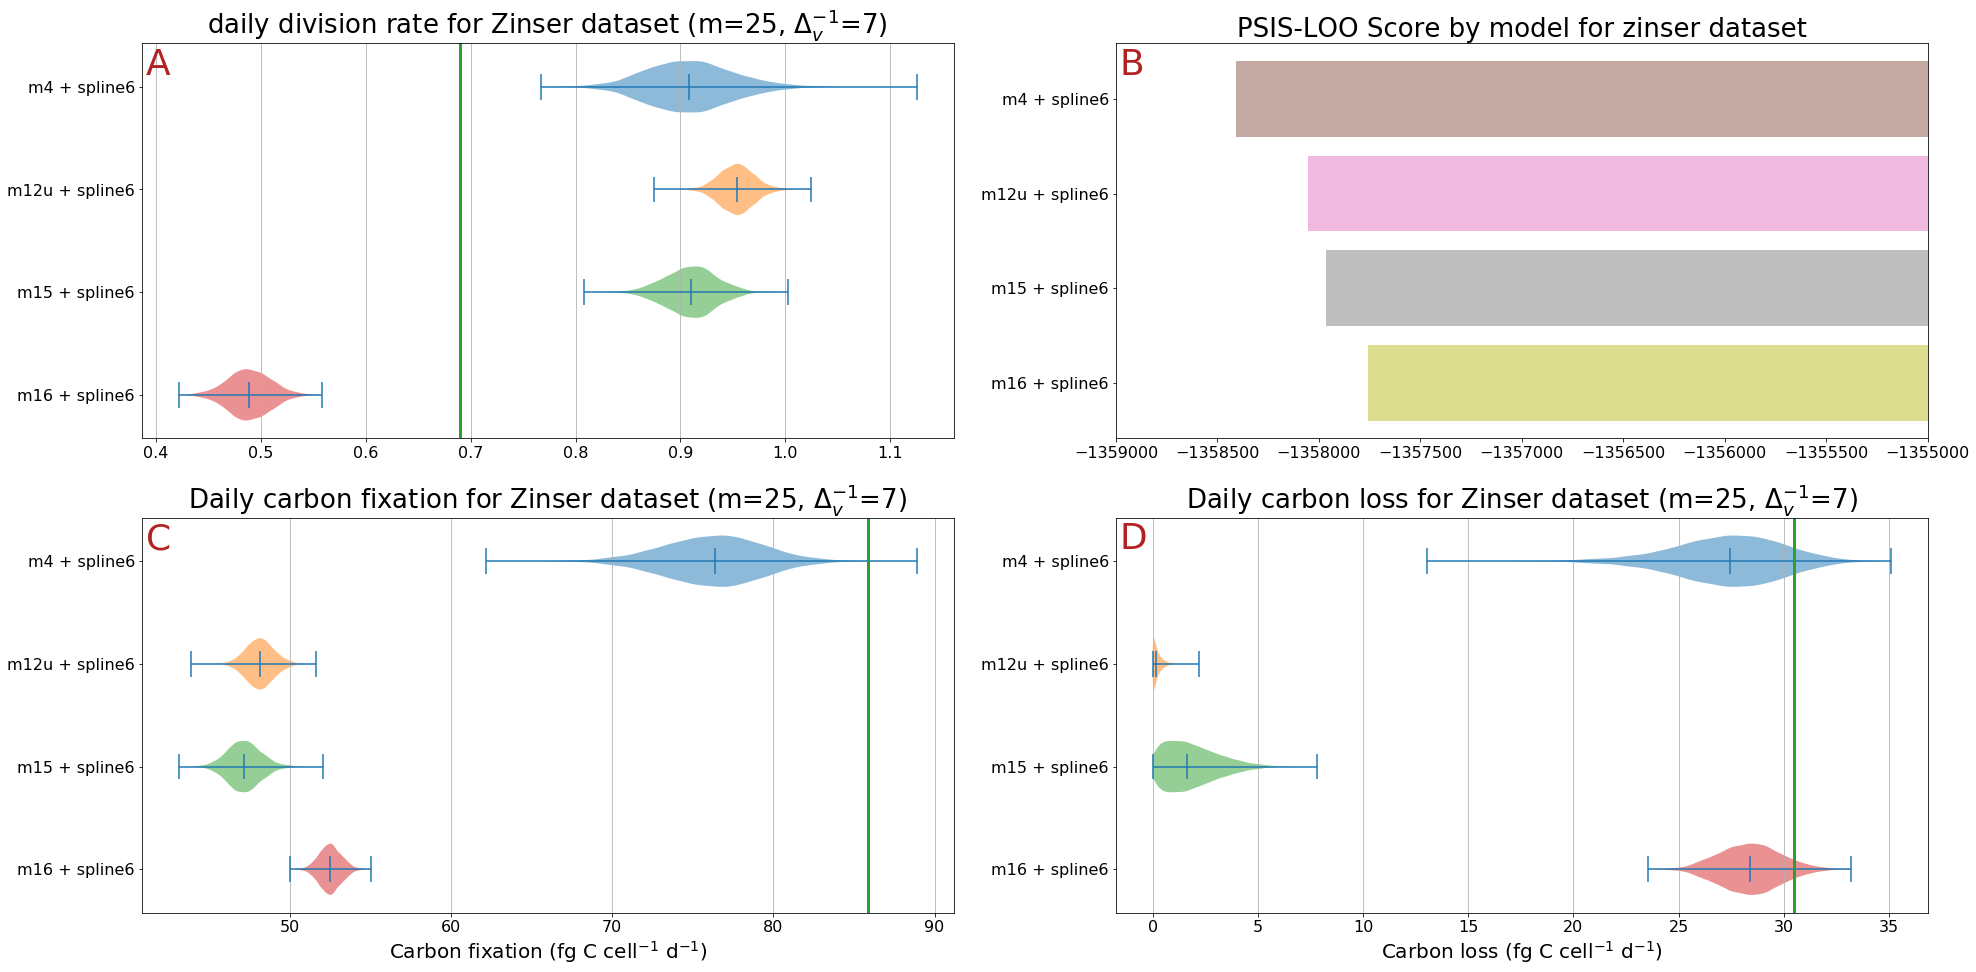

In [18]:
if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'

prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'respiration + exudation\n({} h$^{{-1}}$)'.format(size_units),
}

for dataname in ['zinser']:
    for param in ('divrate',):
        temp_mcmcs = {key: mcmcs[key] for key in mcmcs if 's6' in key}
        num_mcmcs = len(temp_mcmcs)
        fig, axs = plt.subplots(2, 2, figsize=(32,4*num_mcmcs))
        
        ax = axs[0, 0]
        ax.set_title('{} for {}'.format(param_desc[param], desc[dataname]))
        plot = ax.violinplot([temp_mcmcs[model][dataname][param] for model in temp_mcmcs],
                             showmedians=True, vert=False)
        ii = 0
        for pc in plot['bodies']:
            pc.set_facecolor(colors_model[list(models)[ii]])
            pc.set_alpha(0.5)
            ii += 1
        ax.invert_yaxis()
        ax.grid(axis='x')
        ax.set(yticks=np.arange(1,num_mcmcs+1),
               yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs])
        if dataname in reference_values and param in reference_values[dataname]:
            ax.axvline(reference_values[dataname][param], color='tab:green', lw=3)
        ax.text(0.005, 0.92, 'A', transform = ax.transAxes, color='firebrick', fontsize=fontsize)

        ax = axs[0, 1]
        ax.barh(np.arange(len(temp_mcmcs)),
                    [float(loos[model][dataname]) for model in temp_mcmcs],
                    color=[colors_model[model] for model in temp_mcmcs], alpha=0.5)
        ax.invert_yaxis()
        if 'zinser' in dataname:
            ax.set_xlim(-1359000, -1355000)
        elif 'seaflow' in dataname:
            ax.set_xlim(-856000, -852000)
        ax.set_title('PSIS-LOO Score by model for {} dataset'.format(dataname))
        ax.set(yticks=np.arange(0,num_mcmcs),
               yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs])
        ax.text(0.005, 0.92, 'B', transform = ax.transAxes, color='firebrick', fontsize=fontsize)

        t = data[dataname]['dt']*np.arange(data[dataname]['nt'])/60.0
        dt_h = data[dataname]['dt']/60.0
        
        daily_props = {}
        
        for prop in ['growth', 'respiration']:
            
            daily_props[prop] = {}
            
            for model in temp_mcmcs:

                cell_count = temp_mcmcs[model][dataname]['cell_count']

                if prop == 'growth':
                    plotprop = temp_mcmcs[model][dataname]['growth_size_gain']/cell_count/dt_h
                    x = t
                elif prop == 'respiration':
                    plotprop = temp_mcmcs[model][dataname]['resp_size_loss']/cell_count/dt_h
                    x = t
                else:
                    raise ValueError('Unknown prop "{}".'.format(prop))
                
                daily_prop = np.mean(plotprop, axis=1)*24
                
                daily_props[prop][model] = daily_prop
        
        labels = {'growth': 'C', 'respiration': 'D'}
                
        for ax, prop in zip(axs[1, :], ('growth', 'respiration')):
            if dataname == 'zinser':
                with nc4.Dataset('data/zinser_growthdivresp.nc') as nc:
                    true_prop = np.mean(np.maximum(0.0, nc[prop+'/'+prop][:]))*24
            
            title_labels = {'growth': 'carbon fixation', 'respiration': 'carbon loss'}
            xlabels = {'growth': 'Carbon fixation ({} d$^{{-1}}$)'.format(size_units),
                      'respiration': 'Carbon loss ({} d$^{{-1}}$)'.format(size_units)}
            
            ax.set_title('{} for {}'.format('Daily {}'.format(title_labels[prop]), desc[dataname]))
            plot = ax.violinplot([daily_props[prop][model] for model in daily_props[prop]],
                                 showmedians=True, vert=False)
            ax.set(xlabel=xlabels[prop])
            ii = 0
            for pc in plot['bodies']:
                pc.set_facecolor(colors_model[list(models)[ii]])
                pc.set_alpha(0.5)
                ii += 1
            ax.invert_yaxis()
            ax.grid(axis='x')
            ax.set(yticks=np.arange(1,num_mcmcs+1),
                   yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs])
            if 'zinser' in dataname:
                ax.axvline(true_prop, color='tab:green', lw=3)
            if dataname in reference_values and prop in reference_values[dataname]:
                ax.axvline(reference_values[dataname][param], color='tab:green', lw=3)
            ax.text(0.005, 0.92, labels[prop], transform = ax.transAxes, color='firebrick', fontsize=fontsize)

### Figure 6

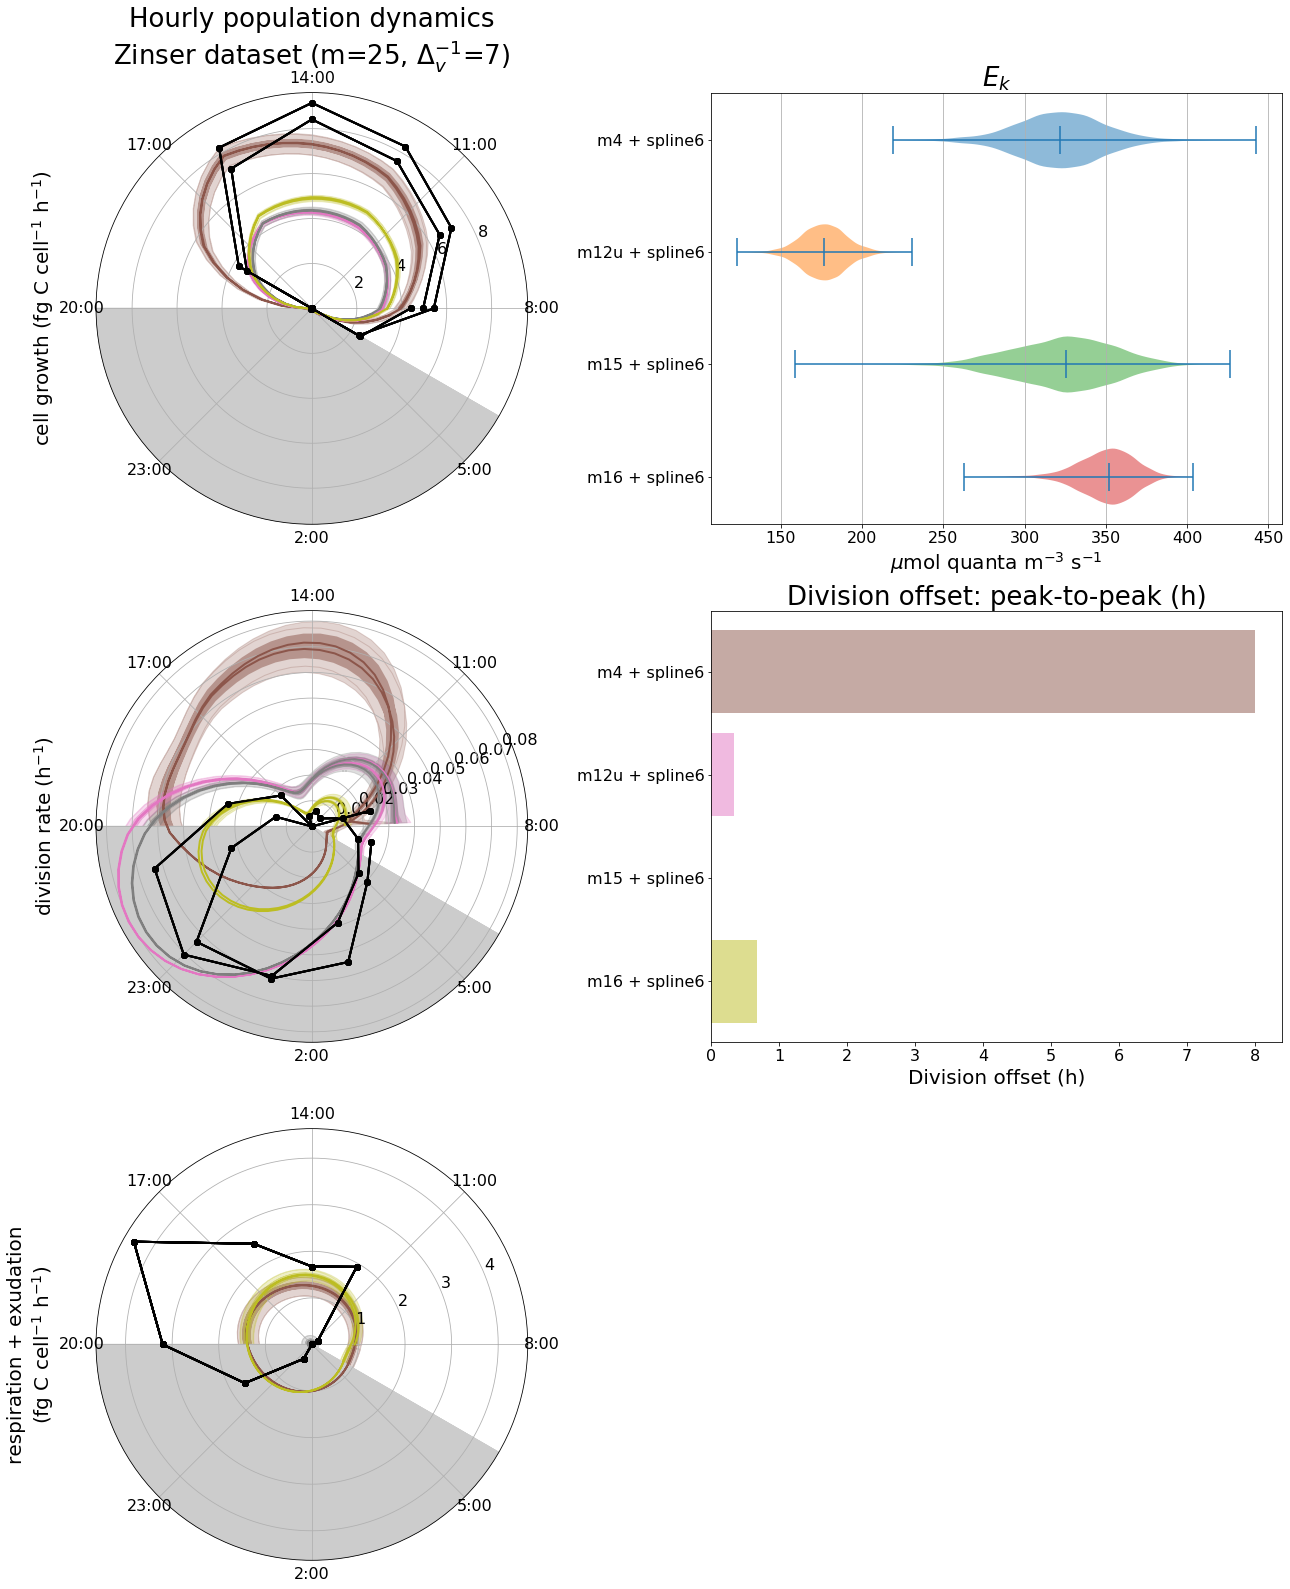

In [19]:
if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'
prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'respiration + exudation\n({} h$^{{-1}}$)'.format(size_units),
}
for dataname in ['zinser']:
    fig = plt.figure(figsize=(9*2.5, 9*3))
    temp_mcmcs = {key: mcmcs[key] for key in mcmcs if 's6' in key}
    t = data[dataname]['dt']*np.arange(data[dataname]['nt'])/60.0
    dt_h = data[dataname]['dt']/60.0
    
    grids = gridspec.GridSpec(1, 2, figure=fig)
    
    polar_grid = grids[0].subgridspec(3, 1)
    
    ii = 0
    mod_maxes = {}
    for prop in ('growth', 'division', 'respiration'):
        ax = fig.add_subplot(polar_grid[ii], polar=True)
        
        for model in temp_mcmcs:
            cell_count = temp_mcmcs[model][dataname]['cell_count']
        
            if prop == 'growth':
                plotprop = temp_mcmcs[model][dataname]['growth_size_gain']/cell_count/dt_h
                x = t * (np.pi/12.0)
            elif prop == 'division':
                plotprop = (np.log(cell_count[:,1:])-np.log(cell_count[:,:-1]))/(t[1:]-t[:-1])
                x = 0.5 * (t[1:] + t[:-1]) * (np.pi/12.0)
                temp = np.mean(plotprop, axis=0)
                mod_max = np.where(temp == np.max(temp[0:72]))[0][0]/3
                mod_maxes[model] = mod_max
            elif prop == 'respiration':
                plotprop = temp_mcmcs[model][dataname]['resp_size_loss']/cell_count/dt_h
                x = t * (np.pi/12.0)
            else:
                raise ValueError('Unknown prop "{}".'.format(prop))
            qq = np.percentile(plotprop, q=(5,25,50,75,95), axis=0)
            sc = ax.fill_between(x, qq[0,:], qq[-1,:], alpha=0.25, color=colors_model[model])
            ax.fill_between(x, qq[1,:], qq[-2,:], alpha=0.5, facecolor=sc.get_facecolor()[0])
            ax.plot(x, qq[2,:], color=sc.get_facecolor()[0][:-1], lw=2)
            if dataname == 'zinser':
                with nc4.Dataset('data/zinser_growthdivresp.nc') as nc:
                    ax.plot(nc[prop+'/time'][:]*(np.pi/12.0), np.maximum(0.0, nc[prop+'/'+prop][:]),
                            color='black', marker='o', lw=2)
                    if prop == 'division':
                        temp = np.maximum(0.0, nc[prop+'/'+prop][:])
                        true_max = np.where(temp == np.max(temp[0:12]))[0][0]*2
            ax.set_ylim(bottom=0.0)
            ax.set_ylabel(prop_labels[prop], labelpad=40)
            ax.set_xticklabels(['{:d}:{:02d}'.format((int(t*(12/np.pi)+8)%24), int(60*(t*(12/np.pi)%1.0)))
                                for t in ax.get_xticks()])
            # darkness from 20:00 to 6:00
            # ymax > 1 needed because it's a polar plot
            ax.axvspan(720*(np.pi/720.0), (1440-120)*(np.pi/720.0), color='0.8', ymax=10, zorder=1)
            ax.grid(True)
        if ii == 0:
            ax.set_title('Hourly population dynamics' + '\n' + desc[dataname])
        ii += 1
    
    reg_grid = grids[1].subgridspec(3, 1)
    
    param = 'E_star'
    ax = fig.add_subplot(reg_grid[0])
    plot = ax.violinplot([temp_mcmcs[model][dataname][param] for model in temp_mcmcs],
                             showmedians=True, vert=False)
    ii = 0
    for pc in plot['bodies']:
        pc.set_facecolor(colors_model[list(models)[ii]])
        pc.set_alpha(0.5)
        ii += 1
    ax.invert_yaxis()
    ax.grid(axis='x')
    ax.set(yticks=np.arange(1,num_mcmcs+1),
           yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs])
    ax.set_title(r'$E_k$')
    ax.set_xlabel(r'$\mu$mol quanta m$^{-3}$ s$^{-1}$')
    if dataname in reference_values and param in reference_values[dataname]:
        ax.axvline(reference_values[dataname][param], color='tab:green', lw=3)
        
    ax = fig.add_subplot(reg_grid[1])
    div_lag = [true_max - mod_maxes[model] for model in temp_mcmcs]
    ax.barh(np.arange(len(temp_mcmcs)),
                    div_lag,
                    color=[colors_model[model] for model in temp_mcmcs], alpha=0.5)
    ax.invert_yaxis()
    ax.set_title('Division offset: peak-to-peak (h)')
    ax.set(yticks=np.arange(0,num_mcmcs),
           yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs],
           xlabel='Division offset (h)')

### Figure 7

Now we apply some of these models to SeaFlow data and examine the results.

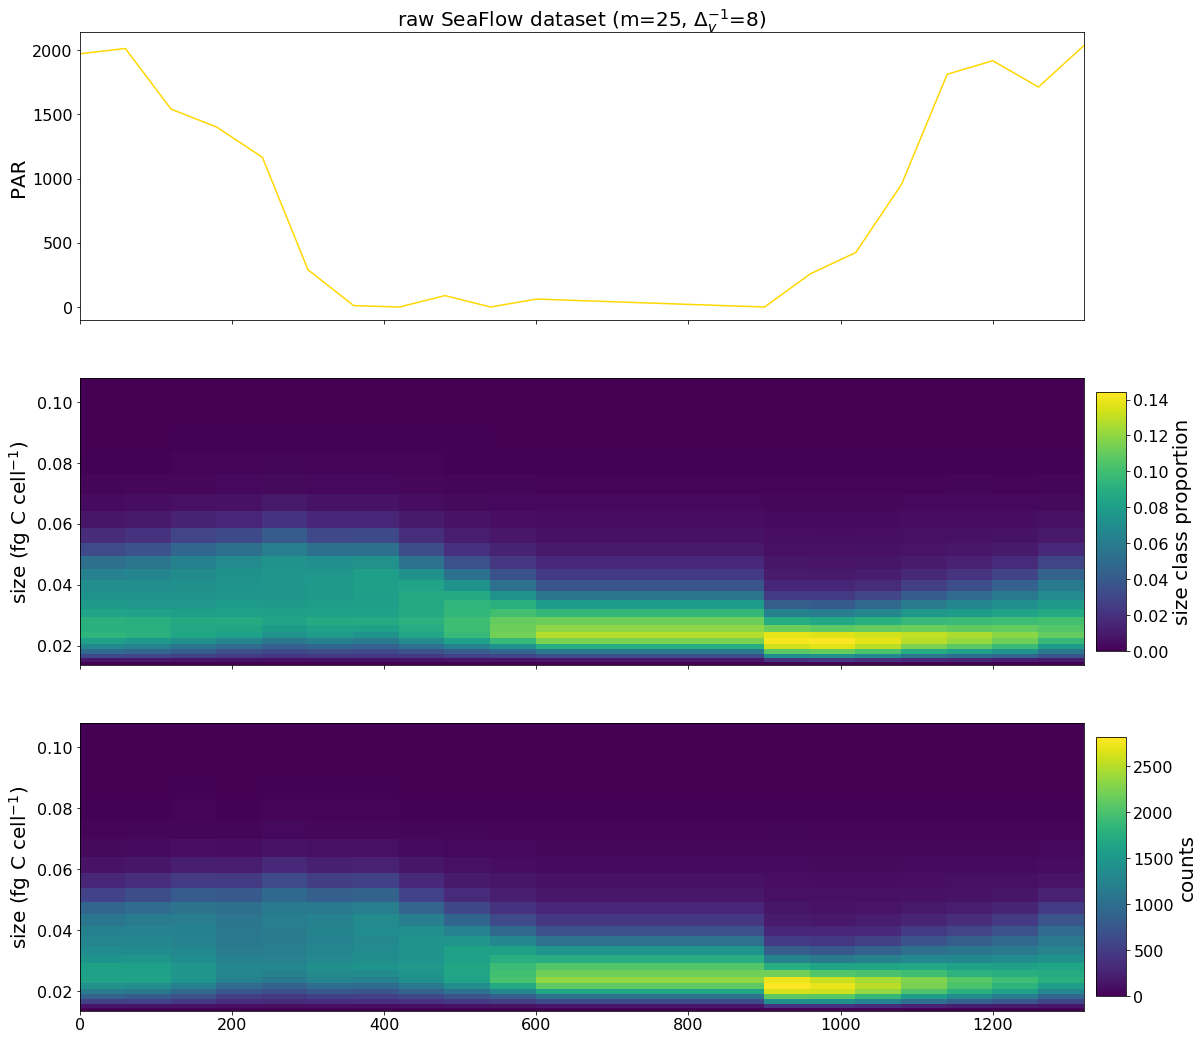

In [20]:
def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1),
                            bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'

prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'respiration + exudation\n({} h$^{{-1}}$)'.format(size_units),
}

if show_data:
    for i,dataname in enumerate(data_gridded):
        if 'seaflow' in dataname:
            nrows = 3

            v_min = data_gridded[dataname]['v_min']
            delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
            v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 

            fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(18,6*nrows))

            ax = axs[0]
            ax.set_title('raw '+desc[dataname], size=20)
            ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
            ax.set(ylabel='PAR')

            ax = axs[1]
            pc = ax.pcolormesh(data_gridded[dataname]['time'], v, data_gridded[dataname]['w_obs'], shading='auto')
            ax.set(ylabel='size ({})'.format(size_units))
            #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
            add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

            ax = axs[2]
            pc = ax.pcolormesh(data_gridded[dataname]['time'], v, data_gridded[dataname]['counts'], shading='auto')
            ax.set(ylabel='size ({})'.format(size_units))
            #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
            add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
None